In [5]:
import os
import pandas as pd
import imagesize
import matplotlib.pyplot as plt

In [2]:
class_names = {
    0:'person',
    1:'car', 
    2:'truck', 
    3:'uav', 
    4:'airplane', 
    5:'ship'
}

In [3]:
def inspect_dataset(
    target_dataset_root, # ../datasets/new_dataset
    target_dataset_slice, # train,test,val
):
    info = [] #list of lists, each list corresponds to an instance [cls_id, x, y, w, h, img]
    
    
    target_labels_dir = os.path.join(target_dataset_root, 'labels', target_dataset_slice)

    # Iterate over all files in the original dataset labels folder
    for filename in os.listdir(target_labels_dir):
        if filename.endswith('.txt'):
            # Read file
            with open(os.path.join(target_labels_dir, filename), "r") as f:
                # Iterate over instances in image and get present class ids
                for line in f:
                    line_data = []
                    # label data
                    line_data = line.split()
                    # Image name
                    line_data.append(os.path.splitext(filename)[0])
                    # Image size: could be done at image level and not row level
                    img_path = os.path.join(target_dataset_root,'images',target_dataset_slice, os.path.splitext(filename)[0]+'.jpg')
                    img_w, img_h = imagesize.get(img_path)
                    line_data.extend([img_w, img_h])
                    # Append line data to info
                    info.append(line_data)

    df = pd.DataFrame(info, columns=['new_class_id', 'xcn', 'ycn', 'wn', 'hn', 'img', 'img_w', 'img_h'])
    df = df.astype({'new_class_id':'int32', 'xcn':'float32', 'ycn':'float32', 'wn':'float32', 'hn':'float32', 'img':'int64', 'img_w':'float32', 'img_h':'float32'})
    df['class_name'] = df['new_class_id'].map(class_names)
    return df

In [6]:
df = inspect_dataset('/Users/inaki-eab/Desktop/datasets/custom_no_coco', 'val')
df

,new_class_id,xcn,ycn,wn,hn,img,img_w,img_h,class_name
0,1,0.113008,0.516769,0.038066,0.033807,3644,1624.0,1200.0,car
1,3,0.178125,0.514583,0.142188,0.129167,5235,1280.0,720.0,uav
2,2,0.133789,0.624621,0.263099,0.326515,1053,1624.0,1200.0,truck
3,0,0.435513,0.559848,0.013435,0.051515,1053,1624.0,1200.0,person
4,0,0.406404,0.558333,0.010076,0.034849,1053,1624.0,1200.0,person
...,...,...,...,...,...,...,...,...,...
42832,1,0.406055,0.520774,0.016188,0.020995,4132,1624.0,1200.0,car
42833,1,0.440119,0.525339,0.023608,0.026472,4132,1624.0,1200.0,car
42834,0,0.455295,0.534467,0.012141,0.048380,4132,1624.0,1200.0,person
42835,1,0.558832,0.561395,0.087012,0.082156,4132,1624.0,1200.0,car


In [7]:
print(f"The number of objects is {len(df)}")
print(f"The number of images is {len(df['img'].unique())}")

The number of objects is 42837
The number of images is 8036


In [8]:
# Create dir to store plots
save_dir = './data/dataset_creation'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

In [9]:
dataset_prefix = 'cnc_val'

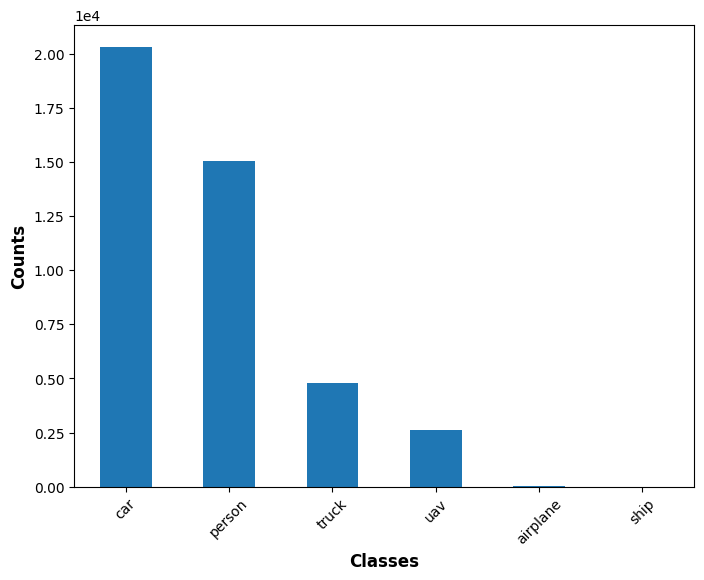

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = df['class_name'].value_counts().plot(kind='bar')
# Set x-axis label
ax.set_xlabel("Classes", weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("Counts", weight='bold', size=12)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
None
fig.savefig(save_dir+f'/{dataset_prefix}_class_counts.png', bbox_inches = 'tight')

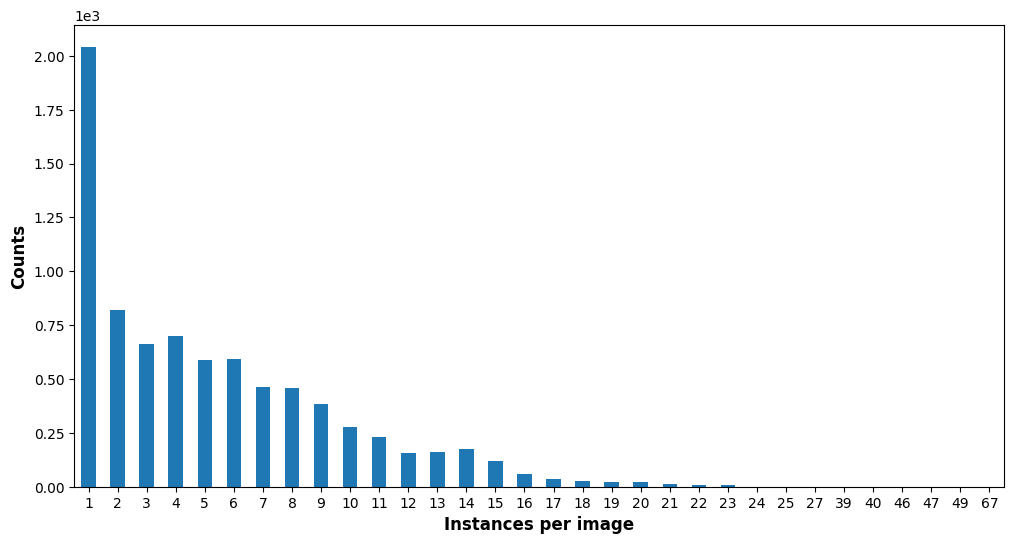

In [11]:
fig = plt.figure(figsize=(12, 6))
ax = df.groupby(by=['img'])['img'].count().value_counts().sort_index().plot(kind='bar')
# Set x-axis label
ax.set_xlabel("Instances per image", weight='bold', size=12)
# Set y-axis label
ax.set_ylabel("Counts", weight='bold', size=12)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
None
fig.savefig(save_dir+f'/{dataset_prefix}_instances_count.png', bbox_inches = 'tight')

#### NEW PROCEEDING REGARDING BBOX AREA CATEGORIZATION
Categories will be defined by the ration of the bbox to its image. In MS COCO images are 640x480 and the classification is done like:
- Tiny: less than 16^2 $\Rightarrow 16^2/(640*480)=1/1200$
- Small: less than 32^2 $\Rightarrow 32^2/(640*480)=1/300$
- Medium: less than 96^2 $\Rightarrow 96^2/(640*480)=3/100$
- Large: more than 96^2 $\Rightarrow 96^2/(640*480)=3/100$


In [13]:
df['bbox_area'] = (df['wn']*df['img_w'])*(df['hn']*df['img_h'])
df['bbox_image_area_ration'] = df['bbox_area']/(df['img_w']*df['img_h'])

bin_edges = [0, 1/1200, 1/300, 3/100, float('inf')]
bin_labels = ['tiny', 'small', 'medium', 'large']
df['bbox_size_category'] = pd.cut(df['bbox_image_area_ration'], bins=bin_edges, labels=bin_labels, right=False)

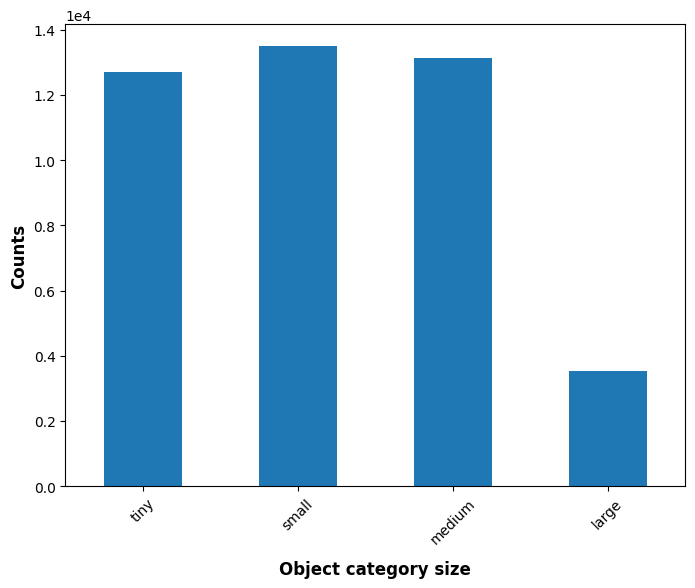

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = df['bbox_size_category'].value_counts().sort_index().plot(kind='bar')
# Set x-axis label
ax.set_xlabel("Object category size", weight='bold', size=12, labelpad=10)
# Set y-axis label
ax.set_ylabel("Counts", weight='bold', size=12)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
None
fig.savefig(save_dir+f'/{dataset_prefix}_objsz_counts.png', bbox_inches = 'tight')